# `WDM` on zf

# running `WDM` on zf

## imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scanpy -q

In [3]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib

In [4]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_save = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca/'

sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_save)
sys.path.insert(0, filehandle_zf)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

## reload

In [5]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## load zf: spatial, annotation hard clusterings as $Q$'s

In [7]:
# daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
# adata_daniocell = sc.read_h5ad(daniocell_dir)
# stages = np.unique(adata_daniocell.obs['hpf'].values)

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [None, None, None, None, None, None] # [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)

In [8]:
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)

key = 'bin_annotation'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    # sc.pp.normalize_total(adata1)
    # sc.pp.log1p(adata1)

    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    # sc.pp.normalize_total(adata2)
    # sc.pp.log1p(adata2)

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Slice pair 4, aligning zf18 to zf24
Slice pair 3, aligning zf12 to zf18
Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [9]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]
# exclude_rows = [1099, None, None, 325, None, None]

i=2

## load features and spatial coords specific to the triple

In [10]:
s1_name = zf_names[i]
s2_name = zf_names[i+1]
s3_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair1 + s2_name + '_feature.npy')
X3 = np.load(filehandle_pair2 + s3_name + '_feature.npy')

S1 = spatial_list[i]
S2 = spatial_list[i+1]
S3 = spatial_list[i+2]

## form cost matrices

In [11]:
C12_np = cdist(X1, X2)
C23_np = cdist(X2, X3)

A11_np = cdist(S1, S1)
A22_np = cdist(S2, S2)
A33_np = cdist(S3, S3)

In [12]:
C12 = torch.from_numpy(C12_np).to(device)
C23 = torch.from_numpy(C23_np).to(device)

A11 = torch.from_numpy(A11_np).to(device)
A22 = torch.from_numpy(A22_np).to(device)
A33 = torch.from_numpy(A33_np).to(device)

## alternate idea for cost matrices

In [13]:
# code now in util_zf.py
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

## set truncation, time

In [14]:
## set truncation
truncation = 100
time = 25.0

In [15]:
%%time
X1_HDM = util_zf.HDM_from_XS(S1, X1, truncation=truncation, time=time)

CPU times: user 19.3 s, sys: 8.84 s, total: 28.1 s
Wall time: 2.94 s


In [16]:
%%time
X2_HDM = util_zf.HDM_from_XS(S2, X2, truncation=truncation, time=time)

CPU times: user 33.1 s, sys: 20 s, total: 53.1 s
Wall time: 5.2 s


In [17]:
%%time
X3_HDM = util_zf.HDM_from_XS(S3, X3, truncation=truncation, time=time)

CPU times: user 19.4 s, sys: 11.9 s, total: 31.3 s
Wall time: 3.08 s


## overriding old cost matrices

In [18]:
A11_HDM_np = cdist(X1_HDM, X1_HDM)
A22_HDM_np = cdist(X2_HDM, X2_HDM)
A33_HDM_np = cdist(X3_HDM, X3_HDM)

## OVERRIDING euclidean cost matrices:
A11 = torch.from_numpy(A11_HDM_np).to(device)
A22 = torch.from_numpy(A22_HDM_np).to(device)
A33 = torch.from_numpy(A33_HDM_np).to(device)

## set ranks, excluded rows for triple

In [19]:
r1, r2 = ranks[i]
r2, r3 = ranks[i+1]
nidx_1, nidx_2, nidx_3 = exclude_rows[i], exclude_rows[i+1], exclude_rows[i+2]

## factor cost matrices

In [20]:
C_factors12, A_factors11, A_factors22 = util_zf.factor_mats(C12, A11_np, A22_np, \
                                                device, z=400, c=100, nidx_1=nidx_1, nidx_2=nidx_2)

C_factors23, A_factors22, A_factors33 = util_zf.factor_mats(C23, A22_np, A33_np, \
                                                device, z=400, c=100, nidx_1=nidx_2, nidx_2=nidx_3)

c = max(torch.max(C_factors12[0] @ C_factors12[1]), torch.max( C_factors23[0] @ C_factors23[1]))
c = max(c, 1/c)

C_factors12 = (C_factors12[0]/c, C_factors12[1]/c)
C_factors23 = (C_factors23[0]/c, C_factors23[1]/c)

C done
A done
B done
C done
A done
B done


## set OT hyperparameters

In [21]:
gamma=500
tau_out=1e3
tau_in=1e-7
alpha = 0.5
beta = 0.0

max_iter=75
min_iter=75

ranks = [(7,11),(11,14)]

## run `WDM`

Aligning slices zf10 to zf12 to zf18
Iteration: 0
Iteration: 25
Iteration: 50
Initial Wasserstein cost: 2.641977381132093e-09, GW-cost: 1.2348735681070135e-15, Total cost: 1.3209893080028306e-09
Final Wasserstein cost: 2.2711565926216478e-09, GW-cost: 1.1628459400358485e-15, Total cost: 1.1355788777337938e-09


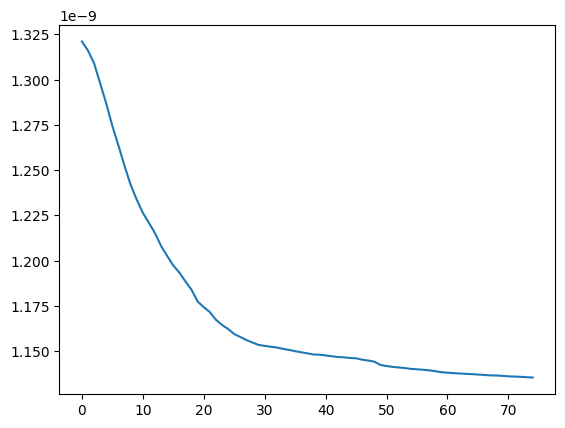

Iteration: 0
Iteration: 25
Iteration: 50
Initial Wasserstein cost: 2.945511990573161e-09, GW-cost: 9.122415887951675e-16, Total cost: 1.472756451407375e-09
Final Wasserstein cost: 2.4789660656062038e-09, GW-cost: 7.959741710011736e-16, Total cost: 1.2394834307901874e-09


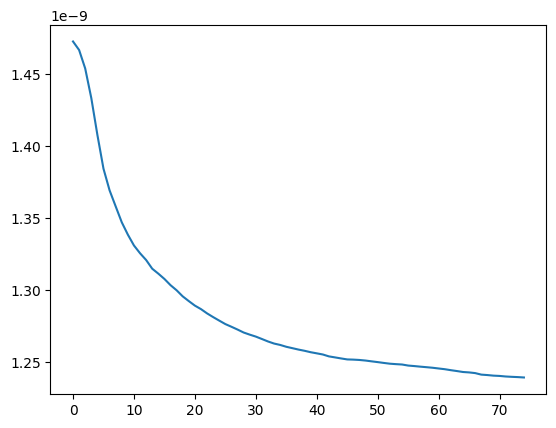

Ranks: r1 7, r2 11, r3 14
Iteration: 0
Iteration: 25
Iteration: 50
Initial Wasserstein-sum cost: 5.350566259090408e-09
Final Wasserstein-sum cost: 4.77864342580336e-09


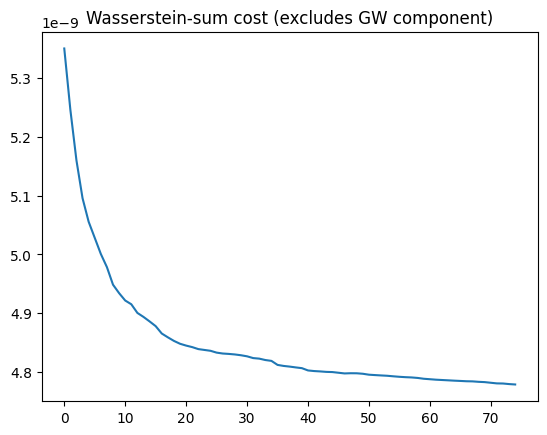

Iteration: 0
Iteration: 25
Iteration: 50
Initial Wasserstein cost: 2.4641933540594097e-09, GW-cost: 1.2409344891023258e-15, Total cost: 1.2320972974969495e-09
Final Wasserstein cost: 2.257070156923688e-09, GW-cost: 1.20503194117221e-15, Total cost: 1.1285356809778144e-09


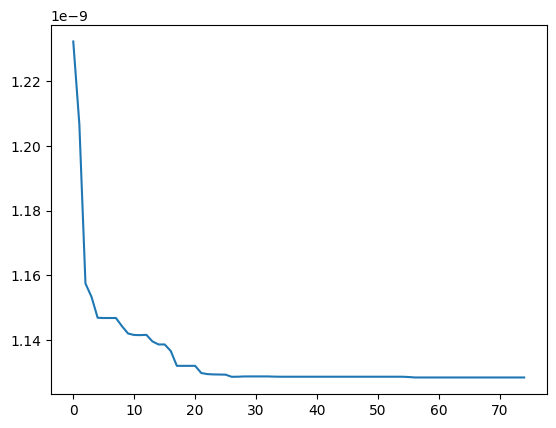

Iteration: 0
Iteration: 25
Iteration: 50
Initial Wasserstein cost: 2.690734463814825e-09, GW-cost: 8.563091097827257e-16, Total cost: 1.3453676600619674e-09
Final Wasserstein cost: 2.5279002677837297e-09, GW-cost: 7.997001163911845e-16, Total cost: 1.263950533741923e-09


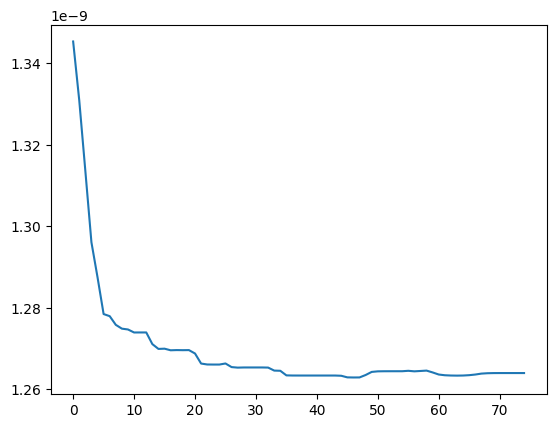

In [22]:
import importlib
import WassersteinDiffMap
importlib.reload(WassersteinDiffMap)


C_factors_sequence, A_factors_sequence = (C_factors12, C_factors23), (A_factors11, A_factors22, A_factors33)

print(f'Aligning slices {s1_name} to {s2_name} to {s3_name}')

WDM = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                  gamma=gamma, max_iter=max_iter, min_iter=min_iter, device=device, dtype=torch.float64, \
                 printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                  initialization='Full', init_args = None)

WDM.gamma_smoothing(C_factors_sequence, A_factors_sequence)

## save

In [23]:
Q0, Q1, Q2 = WDM.Q_gammas[0], WDM.Q_gammas[1], WDM.Q_gammas[2]
T0, T1 = WDM.T_gammas[0], WDM.T_gammas[1]

Q0_np = Q0.cpu().numpy()
Q1_np = Q1.cpu().numpy()
Q2_np = Q2.cpu().numpy()

T0_np = T0.cpu().numpy()
T1_np = T1.cpu().numpy()

np.save(filehandle_save + 'wdm_Q0.npy', Q0_np)
np.save(filehandle_save + 'wdm_Q1.npy', Q1_np)
np.save(filehandle_save + 'wdm_Q2.npy', Q2_np)

np.save(filehandle_save + 'wdm_T0.npy', T0_np)
np.save(filehandle_save + 'wdm_T1.npy', T1_np)

## compare to case where clusters at $t_{1}, t_{3}$ fixed from annotations

Ranks: r1 7, r2 11, r3 14
Iteration: 0
Iteration: 25
Iteration: 50
Initial Wasserstein-sum cost: 5.483015335574718e-09
Final Wasserstein-sum cost: 5.091776006934732e-09


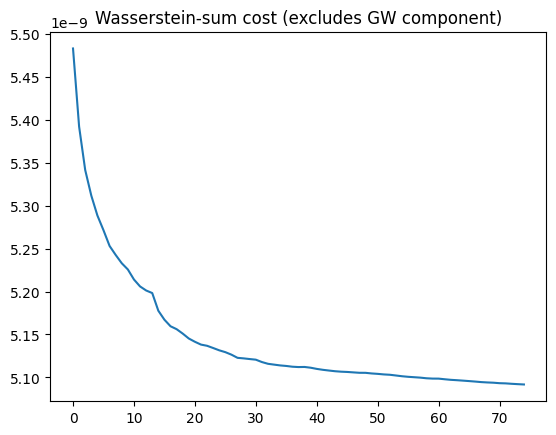

tensor([0.0937, 0.0957, 0.0828, 0.0844, 0.0952, 0.0873, 0.0841, 0.0882, 0.1017,
        0.0833, 0.0911], device='cuda:0', dtype=torch.float64)


In [24]:
# Initialize as arguments
init_args = (Qs[i].type(torch.DoubleTensor).to(device), Rs[i+1].type(torch.DoubleTensor).to(device))
Q0_ann, Q2_ann = init_args

# Learn smoothed co-clustering Q_t
Q1_imp, T0_ann_imp, T1_ann_imp = FRLC_LRDist.FRLC_LR_opt_multimarginal(C_factors12, \
                                              A_factors11, \
                                             A_factors22, \
                                                C_factors23, \
                                              A_factors22, \
                                             A_factors33,  \
                                            r=r2, max_iter=max_iter, device=device, \
                                             returnFull=False, alpha=alpha, beta=beta, \
                                            min_iter=min_iter, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                            dtype=torch.float64, init_args=init_args)
gQ = Q1_imp.T @ torch.ones(Q1_imp.shape[0]).type(torch.DoubleTensor).to(device)
print(gQ)

## save these as well

In [25]:
Q0, Q1, Q2 = Q0_ann, Q1_imp, Q2_ann
T0, T1 = T0_ann_imp, T1_ann_imp

Q0_np = Q0.cpu().numpy()
Q1_np = Q1.cpu().numpy()
Q2_np = Q2.cpu().numpy()

T0_np = T0.cpu().numpy()
T1_np = T1.cpu().numpy()

np.save(filehandle_save + 'ann_Q0.npy', Q0_np)
np.save(filehandle_save + 'ann_Q1_imp.npy', Q1_np)
np.save(filehandle_save + 'ann_Q2.npy', Q2_np)

np.save(filehandle_save + 'ann_T0_imp.npy', T0_np)
np.save(filehandle_save + 'ann_T1_imp.npy', T1_np)

## finally, find diffmaps when all three slices have fixed annotations

Iteration: 0
Iteration: 25
Iteration: 50
Initial Wasserstein cost: 2.62606006563853e-09, GW-cost: 1.0472156544344625e-15, Total cost: 1.3130305564270924e-09
Final Wasserstein cost: 2.4788417154402255e-09, GW-cost: 1.0300806106968535e-15, Total cost: 1.239421372760418e-09


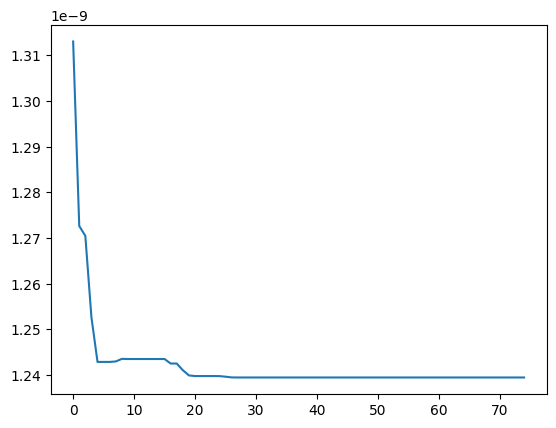

Iteration: 0
Iteration: 25
Iteration: 50
Initial Wasserstein cost: 2.8814172313475546e-09, GW-cost: 8.293760966905786e-16, Total cost: 1.4407090303618257e-09
Final Wasserstein cost: 2.823300219132399e-09, GW-cost: 7.523458858674548e-16, Total cost: 1.4116504857391423e-09


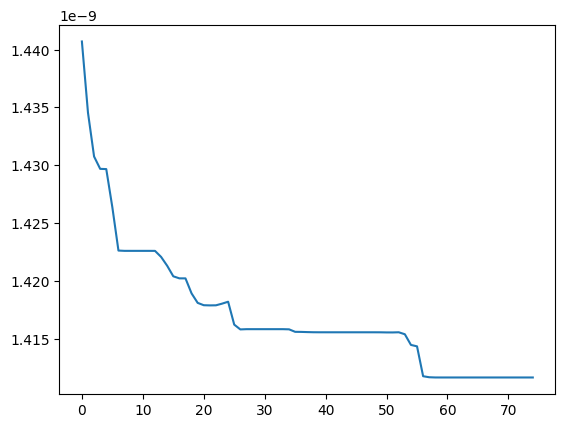

In [26]:
importlib.reload(WassersteinDiffMap)

WDM2 = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                  gamma=gamma, max_iter=max_iter, min_iter=min_iter, device=device, dtype=torch.float64, \
                 printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                  initialization='Full', init_args = None)
Q_annot = [Qs[i].type(torch.DoubleTensor).to(device), Qs[i+1].type(torch.DoubleTensor).to(device), Qs[i+2].type(torch.DoubleTensor).to(device)]
WDM2.impute_annotated_transitions(C_factors_sequence, A_factors_sequence, Q_annot)


## save these

In [27]:
Q0, Q1, Q2 = WDM2.Q_gammas[0], WDM2.Q_gammas[1], WDM2.Q_gammas[2]
T0, T1 = WDM2.T_gammas[0], WDM2.T_gammas[1]

Q0_np = Q0.cpu().numpy()
Q1_np = Q1.cpu().numpy()
Q2_np = Q2.cpu().numpy()

T0_np = T0.cpu().numpy()
T1_np = T1.cpu().numpy()

np.save(filehandle_save + 'ann_Q0.npy', Q0_np)
np.save(filehandle_save + 'ann_Q1.npy', Q1_np)
np.save(filehandle_save + 'ann_Q2.npy', Q2_np)

np.save(filehandle_save + 'ann_T0.npy', T0_np)
np.save(filehandle_save + 'ann_T1.npy', T1_np)

# Analysis

## load output of `WDM`

In [28]:
wdm_Q0 = np.load(filehandle_save + 'wdm_Q0.npy')
wdm_Q1 = np.load(filehandle_save + 'wdm_Q1.npy')
wdm_Q2 = np.load(filehandle_save + 'wdm_Q2.npy')

wdm_T0 = np.load(filehandle_save + 'wdm_T0.npy')
wdm_T1 = np.load(filehandle_save + 'wdm_T1.npy')

ann_Q0 = np.load(filehandle_save+ 'ann_Q0.npy')

ann_Q1 = np.load(filehandle_save + 'ann_Q1.npy')
ann_Q1_imp = np.load(filehandle_save + 'ann_Q1_imp.npy')

ann_Q2 = np.load(filehandle_save + 'ann_Q2.npy')

ann_T0_imp = np.load(filehandle_save + 'ann_T0_imp.npy')
ann_T1_imp = np.load(filehandle_save + 'ann_T1_imp.npy')

ann_T0 = np.load(filehandle_save + 'ann_T0.npy')
ann_T1 = np.load(filehandle_save + 'ann_T1.npy')

### lists of these for the three cases

Qs_ann = [ann_Q0, ann_Q1, ann_Q2]
Ts_ann = [ann_T0, ann_T1]

Qs_ann_imp = [ann_Q0, ann_Q1_imp, ann_Q2]
Ts_ann_imp = [ann_T0_imp, ann_T1_imp]

Qs_wdm = [wdm_Q0, wdm_Q1, wdm_Q2]
Ts_wdm = [wdm_T0, wdm_T1]

## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [29]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]

i=2

r1, r2 = ranks[i]
r2, r3 = ranks[i+1]

## load features and spatial coords specific to the triple

In [30]:
s0_name = zf_names[i]
s1_name = zf_names[i+1]
s2_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X0 = np.load(filehandle_pair1 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')

S0 = spatial_list[i]
S1 = spatial_list[i+1]
S2 = spatial_list[i+2]

Ss = [S0, S1, S2]

## load labels

In [31]:
filehandle_ctd = 'drive/Othercomputers/numac/GitHub/celltypediscovery/'

slice0_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice0_types.npy'))
slice1_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice1_types.npy'))
slice2_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice2_types.npy'))
slice3_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice3_types.npy'))
slice4_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice4_types.npy'))
slice5_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice5_types.npy'))

ct_labels = [ list(set(slice0_types)),
               list(set(slice1_types)),
                list(set(slice2_types)),
                list(set(slice3_types)),
                list(set(slice4_types)),
                list(set(slice5_types))]

ct_ann_0 = ct_labels[i]
ct_ann_1 = ct_labels[i+1]
ct_ann_2 = ct_labels[i+2]

# form cases
cell_type_labels_case_1 = [ct_ann_0, ct_ann_1, ct_ann_2]
cell_type_labels_case_2 = [ct_ann_0, None, ct_ann_2]
cell_type_labels_case_3 = [None, None, None]

## case 1: `ml` clustering,  annotations

In [32]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann,
                        Ts=Ts_ann,
                        cell_type_labels=cell_type_labels_case_1,
                        clustering_type='ml')

Output hidden; open in https://colab.research.google.com to view.

## case 2: `ml` clustering, annotations at $t_1, t_3$

In [33]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann_imp,
                        Ts=Ts_ann_imp,
                        cell_type_labels=cell_type_labels_case_2,
                        clustering_type='ml')

Output hidden; open in https://colab.research.google.com to view.

## case 3: fully unsupervised

In [34]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_wdm,
                        Ts=Ts_wdm,
                        cell_type_labels=cell_type_labels_case_3,
                        clustering_type='ml')

Output hidden; open in https://colab.research.google.com to view.

## focus on case 3, what does differential expression reveal about these clusters, and how do they compare to the annotations?

In [35]:
case3_clusters = clustering.max_likelihood_clustering(Qs_wdm)